In [32]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: C:\D disk\ID2223_lab1\mlfs-book
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [33]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [34]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-05 12:05:37,171 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-05 12:05:37,179 INFO: Initializing external client
2025-11-05 12:05:37,180 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-05 12:05:40,479 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271980


In [35]:
# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name='air_quality',
    version=1,
)
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

In [36]:
# Select features for training data.
selected_features = air_quality_fg.select(['pm25', 'date']).join(weather_fg.select_features(), on=['city'])


#selected_features = (
 #   air_quality_fg.select(['pm25', 'date', 'city'])
  #  .join(weather_fg.select_all(), on=['city', 'date'])
#)


df_preview = selected_features.read()
df_preview.head()


2025-11-05 12:06:12,380 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.92s) 


,pm25,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,129.0,2014-01-01 00:00:00+00:00,1.164167,0.0,14.154915,264.003693
1,193.0,2014-01-02 00:00:00+00:00,0.435000,0.0,11.525623,351.280304
2,110.0,2014-01-03 00:00:00+00:00,-0.119167,0.0,11.966953,90.520851
3,196.0,2014-01-04 00:00:00+00:00,-2.660833,0.0,7.568566,20.897827
4,153.0,2014-01-05 00:00:00+00:00,-1.271250,0.0,11.486200,102.660622


In [37]:
df = selected_features.read()  # 取一部分预览
print("rows:", len(df))

# 若 air_quality 是按 (city, date) 唯一的，看看合并后是否仍唯一
uniq = df.groupby(['date']).size().sort_values(ascending=False).head(10)
print(uniq)  # 若出现 >1 的计数，说明按 city 的 join 发生了倍增

# 如果你能把 city 也选进来（哪怕临时）看看更直观：
df2 = (
    air_quality_fg.select(['pm25','date','city'])
    .join(weather_fg.select_features(), on=['city'])
).read()
dup = df2.groupby(['city','date']).size().sort_values(ascending=False).head(10)
print(dup)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.46s) 
rows: 4244
date
2014-01-01 00:00:00+00:00    1
2021-12-26 00:00:00+00:00    1
2021-12-12 00:00:00+00:00    1
2021-12-13 00:00:00+00:00    1
2021-12-14 00:00:00+00:00    1
2021-12-15 00:00:00+00:00    1
2021-12-16 00:00:00+00:00    1
2021-12-17 00:00:00+00:00    1
2021-12-18 00:00:00+00:00    1
2021-12-19 00:00:00+00:00    1
dtype: int64
2025-11-05 12:06:27,743 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.45s) 
city     date                     
beijing  2014-01-01 00:00:00+00:00    1
         2021-12-26 00:00:00+00:00    1
         2021-12-12 00:00:00+00:00    1
         2021-12-13 00:00:00+00:00    1
         2021-12-14 00:00:00+00:00    1
        

### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [38]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [39]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [40]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 


In [41]:
X_train

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2014-01-01 00:00:00+00:00,1.164167,0.0,14.154915,264.003693
1,2014-01-02 00:00:00+00:00,0.435000,0.0,11.525623,351.280304
2,2014-01-03 00:00:00+00:00,-0.119167,0.0,11.966953,90.520851
3,2014-01-04 00:00:00+00:00,-2.660833,0.0,7.568566,20.897827
4,2014-01-05 00:00:00+00:00,-1.271250,0.0,11.486200,102.660622
...,...,...,...,...,...
4050,2025-04-26 00:00:00+00:00,21.160250,0.0,20.757051,353.850555
4051,2025-04-27 00:00:00+00:00,19.331083,0.0,17.856325,300.839630
4052,2025-04-28 00:00:00+00:00,18.879000,0.0,16.575644,129.157227
4053,2025-04-29 00:00:00+00:00,23.841501,0.0,16.974487,278.392761


In [42]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [43]:
y_train

,pm25
0,129.0
1,193.0
2,110.0
3,196.0
4,153.0
...,...
4050,146.0
4051,29.0
4052,69.0
4053,78.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 4 features (wind_speed, wind_dir, temp, precipitation)

In [44]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [45]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 3604.998
R squared: -2.190546193203578


In [46]:
df = y_test
df['predicted_pm25'] = y_pred

In [47]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
4055,42.0,93.770836,2025-05-01 00:00:00+00:00
4056,63.0,105.251175,2025-05-02 00:00:00+00:00
4057,35.0,88.982567,2025-05-03 00:00:00+00:00
4058,68.0,152.427917,2025-05-04 00:00:00+00:00
4059,99.0,54.531078,2025-05-05 00:00:00+00:00


In [48]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

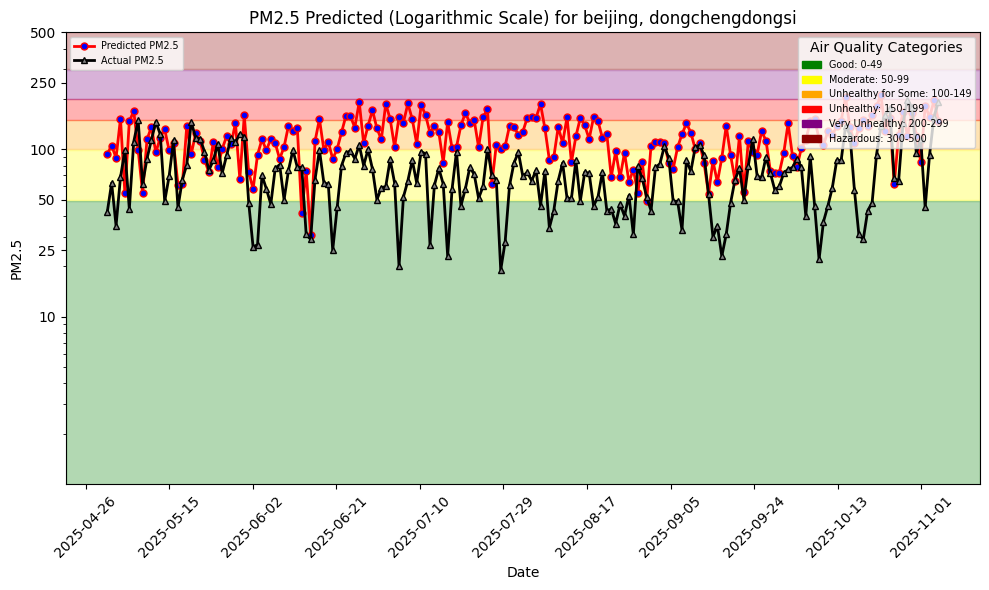

In [49]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

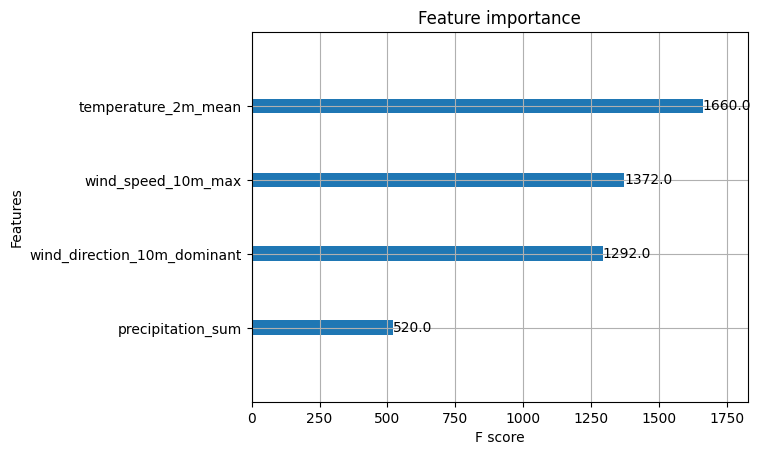

In [50]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [51]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [52]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [53]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\air_quality_model/model.json: 0.000%|          …

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\air_quality_model\images/feature_importance.png…

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\air_quality_model\images/pm25_hindcast.png: 0.0…

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\model_schema.json: 0.000%|          | 0/605 ela…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1271980/models/air_quality_xgboost_model/2


Model(name: 'air_quality_xgboost_model', version: 2)

FV v2b ready: air_quality_fv_v2 3
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (3.11s) 
FV v2b columns (preview): ['date', 'city', 'pm25_lag1', 'pm25_lag2', 'pm25_lag3', 'weather_date', 'weather_temperature_2m_mean', 'weather_precipitation_sum', 'weather_wind_speed_10m_max', 'weather_wind_direction_10m_dominant']  ... total: 10
[PATH B] FeatureView missing weather columns — fallback to local pandas join.
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.33s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.46s) 
Train size: 4052  Test size: 188
Used feature columns: ['pm25_lag1', 'pm25_lag2', 'pm25_lag3', 'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']
{'MSE_v2': 1134.4344482421875, 'R2_v2': -0.03225909010024419}


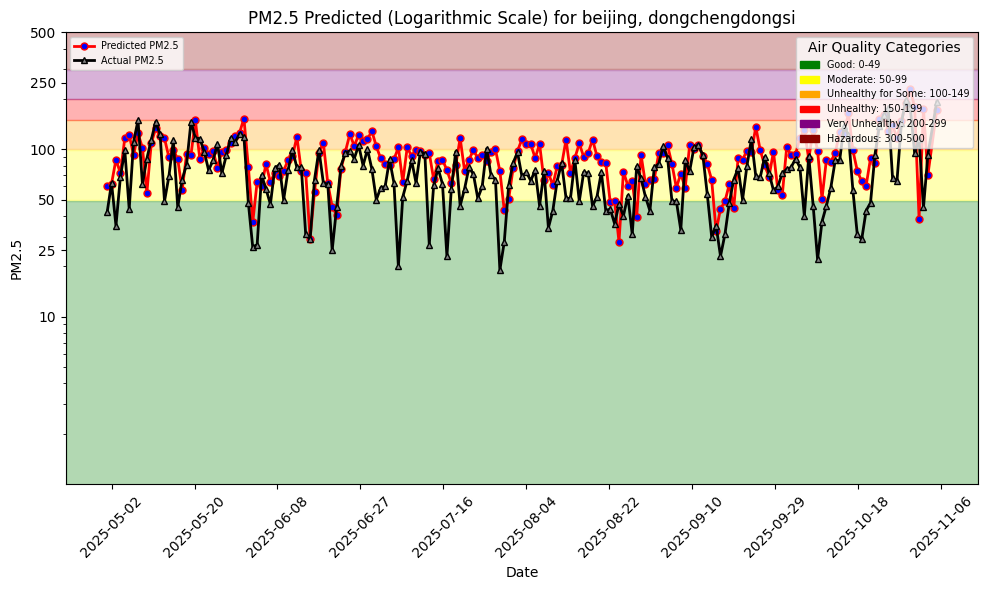

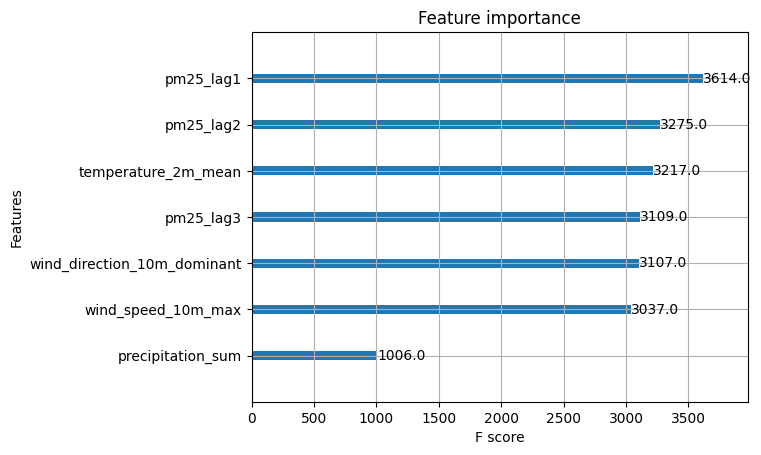

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading C:\D disk\ID2223_lab1\mlfs-book\notebooks\airquality\air_quality_model_v2_localjoin/model.json: 0.00…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1271980/models/air_quality_xgboost_model_lag_localjoin/3
Registered: air_quality_xgboost_model_lag_localjoin


In [61]:
#  FOR C GRADE

# ============================================================
# FG v2 训练与注册（含天气 + 滞后特征），在你现有代码基础上增强
# ============================================================

import os
import pandas as pd
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, r2_score

# 1) 构建新的 Feature View（v2b：version=3）
aq_fg_v2 = fs.get_feature_group(name="air_quality", version=2)
wx_fg_v1 = fs.get_feature_group(name="weather",     version=1)

aq_sel_v2 = aq_fg_v2.select([
    "pm25", "date", "city", "pm25_lag1", "pm25_lag2", "pm25_lag3"
])

# 用 select_all() 确保天气列完整进入
wx_sel_v1 = wx_fg_v1.select_all()

# weather 的主键只有 city，因此按 ["city"] 连接（PIT 依赖 event_time）
selected_features_v2b = aq_sel_v2.join(wx_sel_v1, on=["city"])

feature_view_v2b = fs.get_or_create_feature_view(
    name="air_quality_fv_v2",
    version=3,   # 不覆盖你之前的版本
    description="PM2.5 + pm25_lag1/2/3 + all weather features via city PIT join",
    labels=["pm25"],
    query=selected_features_v2b,
)
print("FV v2b ready:", feature_view_v2b.name, feature_view_v2b.version)

# （可选）快速查看 FV 列，确认天气特征存在（你的 HSFS 版本用 get_batch_data）
fv_cols = feature_view_v2b.get_batch_data().columns.tolist()
print("FV v2b columns (preview):", fv_cols[:50], " ... total:", len(fv_cols))

# 我们真正希望用于训练的数值特征白名单
X_COLS_WANTED = [
    "pm25_lag1", "pm25_lag2", "pm25_lag3",
    "temperature_2m_mean", "precipitation_sum",
    "wind_speed_10m_max", "wind_direction_10m_dominant"
]
WEATHER_COLS = ["temperature_2m_mean","precipitation_sum","wind_speed_10m_max","wind_direction_10m_dominant"]

# =============== 路径 A：尝试直接用 FeatureView 训练 ===============
use_fv_path = all(c in fv_cols for c in WEATHER_COLS)

if use_fv_path:
    print("[PATH A] Training directly from FeatureView v3 (weather cols present).")
    # 2) 读取训练数据并做时间切分
    X_train_v2, X_test_v2, y_train_v2, y_test_v2 = feature_view_v2b.train_test_split(
        test_start=test_start
    )
    # 保存一份带 date 的副本（用于 hindcast 画图）
    X_test_v2_with_date = X_test_v2.copy()

    # 仅选择数值特征白名单，避免把字符串列（如 date）转成 float 造成报错
    X_cols_present = [c for c in X_COLS_WANTED if c in X_train_v2.columns]
    if len(X_cols_present) != len(X_COLS_WANTED):
        print("[WARN] Missing columns in X_*:", sorted(set(X_COLS_WANTED) - set(X_cols_present)))

    X_train_v2 = X_train_v2[X_cols_present]
    X_test_v2  = X_test_v2[X_cols_present]

    # 去掉 lag 缺失样本（可选，但更稳）
    need_lags = [c for c in ["pm25_lag1","pm25_lag2","pm25_lag3"] if c in X_train_v2.columns]
    if need_lags:
        mask_tr = X_train_v2[need_lags].notna().all(axis=1)
        mask_te = X_test_v2[need_lags].notna().all(axis=1)
    else:
        mask_tr = X_train_v2.index.astype(bool)
        mask_te = X_test_v2.index.astype(bool)

    X_train_v2, y_train_v2 = X_train_v2.loc[mask_tr], y_train_v2.loc[mask_tr]
    X_test_v2,  y_test_v2  = X_test_v2.loc[mask_te],  y_test_v2.loc[mask_te]
    X_test_v2_with_date     = X_test_v2_with_date.loc[mask_te]

    # 类型转换：仅数值列与 y
    X_train_v2 = X_train_v2.astype("float32")
    X_test_v2  = X_test_v2.astype("float32")
    y_train_v2 = y_train_v2.iloc[:, 0].astype("float32")
    y_test_v2  = y_test_v2.iloc[:, 0].astype("float32")

    print("Train size:", len(X_train_v2), " Test size:", len(X_test_v2))
    print("Used feature columns:", list(X_train_v2.columns))

    # 训练与评估
    xgb_regressor_v2 = XGBRegressor(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
    xgb_regressor_v2.fit(X_train_v2, y_train_v2)

    y_pred_v2 = xgb_regressor_v2.predict(X_test_v2)
    mse_v2 = float(mean_squared_error(y_test_v2, y_pred_v2))
    r2_v2  = float(r2_score(y_test_v2, y_pred_v2))
    print({"MSE_v2": mse_v2, "R2_v2": r2_v2})

    # 生成 hindcast 图
    df_v2_plot = y_test_v2.to_frame(name="pm25")
    # date 可能存在于 X_test_v2_with_date
    if "date" in X_test_v2_with_date.columns:
        df_v2_plot["date"] = X_test_v2_with_date["date"]
    else:
        # 极少数版本没有把 date 回传到 X_*；这种情况下就放弃画图中的日期
        print("[WARN] 'date' not found in X_test_v2; hindcast x-axis may be unavailable.")
        df_v2_plot["date"] = pd.NaT

    df_v2_plot["predicted_pm25"] = y_pred_v2
    df_v2_plot = df_v2_plot.sort_values("date")

    images_dir = os.path.join(model_dir, "images")
    os.makedirs(images_dir, exist_ok=True)
    file_path_v2 = os.path.join(images_dir, "pm25_hindcast_v2.png")
    plt = util.plot_air_quality_forecast(city, street, df_v2_plot, file_path_v2, hindcast=True)
    plt.show()

else:
    # =============== 路径 B：FV 不带天气列，改用本地 pandas join ===============
    print("[PATH B] FeatureView missing weather columns — fallback to local pandas join.")
    # 1) 读出 air_quality v2 & weather v1 的离线数据
    aq_v2_df = aq_fg_v2.read()[["date","city","pm25","pm25_lag1","pm25_lag2","pm25_lag3"]].copy()
    wx_v1_df = wx_fg_v1.read()[[
        "date","city",
        "temperature_2m_mean","precipitation_sum",
        "wind_speed_10m_max","wind_direction_10m_dominant"
    ]].copy()

    # 统一时间类型为“无时区”，避免 merge 报错
    aq_v2_df["date"] = pd.to_datetime(aq_v2_df["date"], utc=True).dt.tz_convert(None)
    wx_v1_df["date"] = pd.to_datetime(wx_v1_df["date"], utc=True).dt.tz_convert(None)

    # 本地按 ['city','date'] 左连接，把天气拼到 air_quality v2 上
    df_join = pd.merge(
        aq_v2_df, wx_v1_df,
        on=["city","date"], how="left", validate="one_to_one"
    )

    # 丢掉 lag 缺失的样本（可选）
    df_join = df_join.dropna(subset=["pm25_lag1","pm25_lag2","pm25_lag3"])

    # 按你的 test_start 做时间切分
    df_join = df_join.sort_values("date")
    test_start_ts = pd.to_datetime(test_start)
    train_df = df_join[df_join["date"] <  test_start_ts].copy()
    test_df  = df_join[df_join["date"] >= test_start_ts].copy()

    # 取特征与标签（这次一定包含天气列）
    X_cols_present = [c for c in X_COLS_WANTED if c in train_df.columns]
    missing_cols = sorted(set(X_COLS_WANTED) - set(X_cols_present))
    if missing_cols:
        print("[WARN] Weather columns missing after local join:", missing_cols)

    X_train_v2 = train_df[X_cols_present].astype("float32")
    y_train_v2 = train_df["pm25"].astype("float32")
    X_test_v2  = test_df[X_cols_present].astype("float32")
    y_test_v2  = test_df["pm25"].astype("float32")

    print("Train size:", len(X_train_v2), " Test size:", len(X_test_v2))
    print("Used feature columns:", list(X_train_v2.columns))

    # 训练与评估
    xgb_regressor_v2 = XGBRegressor(
        n_estimators=400, max_depth=6, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
    xgb_regressor_v2.fit(X_train_v2, y_train_v2)

    y_pred_v2 = xgb_regressor_v2.predict(X_test_v2)
    mse_v2 = float(mean_squared_error(y_test_v2, y_pred_v2))
    r2_v2  = float(r2_score(y_test_v2, y_pred_v2))
    print({"MSE_v2": mse_v2, "R2_v2": r2_v2})

    # 画 hindcast（用本地切分的数据）
    df_v2_plot = pd.DataFrame({
        "pm25": y_test_v2.values,
        "predicted_pm25": y_pred_v2,
        "date": test_df["date"].values,
    }).sort_values("date")

    images_dir = os.path.join(model_dir, "images")
    os.makedirs(images_dir, exist_ok=True)
    file_path_v2 = os.path.join(images_dir, "pm25_hindcast_v2_localjoin.png")
    plt = util.plot_air_quality_forecast(city, street, df_v2_plot, file_path_v2, hindcast=True)
    plt.show()

# === 共同：特征重要性图（两条路径都会有） ===
plot_importance(xgb_regressor_v2)
plt.savefig(os.path.join(images_dir, "feature_importance_v2.png" if use_fv_path else "feature_importance_v2_localjoin.png"))
plt.show()

# === 保存并注册 lag 模型（新目录/新名字） ===
model_dir_v2 = "air_quality_model_v2" if use_fv_path else "air_quality_model_v2_localjoin"
os.makedirs(model_dir_v2, exist_ok=True)
xgb_regressor_v2.save_model(os.path.join(model_dir_v2, "model.json"))

res_dict_v2 = {"MSE": str(mse_v2), "R squared": str(r2_v2)}
model_name = "air_quality_xgboost_model_lag" if use_fv_path else "air_quality_xgboost_model_lag_localjoin"

aq_model_v2 = mr.python.create_model(
    name=model_name,
    metrics=res_dict_v2,
    feature_view=(feature_view_v2b if use_fv_path else None),
    description=(
        "XGBoost on air_quality_fv_v2 (v3): includes pm25_lag1/2/3 + weather."
        if use_fv_path
        else "XGBoost trained on air_quality v2 + weather v1 (local pandas join)."
    ),
)
aq_model_v2.save(model_dir_v2)

print("Registered:", model_name)



---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
